# 使用 k 近邻算法改进网站的配对效果

**说明：**
* 海伦使用在线约会网站寻找适合自己的约会对象，她总结曾交往过三种类型的人：1不喜欢的人、2魅力一般的人、3极具魅力的人；
* 海伦希望我们的分类软件可以更好地将匹配对象划分到确切的分类中；
* PS：请将数据集文件 'datingTestSet.txt' 放在当前文件夹

In [1]:
# 导入程序所需要的模块
import numpy as np
import operator
import matplotlib
import matplotlib.pyplot as plt

## 1. 准备数据：从文本文件中解析数据

* 海伦收集了一些约会对象的数据信息，保存在'datingTestSet.txt'中；
* 每个样本数据占据一行，包含以下3个特征：每年的飞行里程数、玩视频游戏所耗时间百分比、每周消费的冰激凌公升数；最后一个为她对约会对象的分类；
* file2matrix函数实现的功能是读取文件数据，函数返回的returnMat和classLabelVector分别是数据集的特征矩阵和输出标签向量；

In [2]:
def file2matrix(filename):
    love_dictionary = {'largeDoses':3, 'smallDoses':2, 'didntLike':1}    # 三个类别
    fr = open(filename)                           # 打开文件
    arrayOLines = fr.readlines()                  # 逐行打开
    numberOfLines = len(arrayOLines)              # 得到文件的行数
    returnMat = np.zeros((numberOfLines, 3))      # 初始化特征矩阵
    classLabelVector = []                         # 初始化输出标签向量
    index = 0
    for line in arrayOLines:
        line = line.strip()                       # 删去字符串首部尾部空字符
        listFromLine = line.split('\t')           # 按'\t'对字符串进行分割，listFromLine是列表
        returnMat[index, :] = listFromLine[0:3]   # listFromLine的0,1,2元素是特征，赋值给returnMat的当前行
        
        # 如果最后的分类是字符串，则转换为数字
        if(listFromLine[-1].isdigit()):
            classLabelVector.append(int(listFromLine[-1]))
        else:
            classLabelVector.append(love_dictionary.get(listFromLine[-1]))
            
        index += 1
    return returnMat, classLabelVector            # 返回的类别标签classLabelVector是1,2,3

## 2. 分析数据：使用Matplotlib创建散点图

* 将上述解析后的数据使用图形化的工具展示出来，以便观察数据的分布和特点；

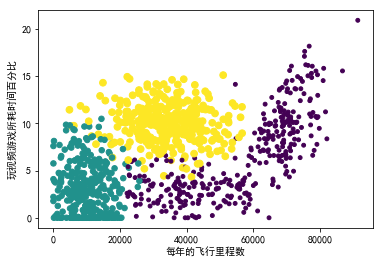

In [3]:
datingDataMat, datingLabels = file2matrix('datingTestSet.txt')
fig = plt.figure()           # 建立一个画布
ax = fig.add_subplot(111)    # 在画布中建立图表，画布分割成1行1列，图像
ax.scatter(datingDataMat[:,0], datingDataMat[:,1], 15.0*np.array(datingLabels), 15.0*np.array(datingLabels))
plt.xlabel('每年的飞行里程数')
plt.ylabel('玩视频游戏所耗时间百分比')
plt.rcParams['font.sans-serif']=['SimHei']    #用来正常显示中文标签
plt.show()

## 3. 准备数据：归一化数值

* 如果需要计算样本之间的距离，发现飞行的里程数对于距离的影响最大，但是海伦认为这三种特征是同等重要的；
* 可以采用数值归一化的方法进行转换为-1到1之间的数值，计算公式为 newValue = (oldValue - min)/(max - min)，其中min和max分别是数据集中最小的和最大的特征值；

In [4]:
def autoNorm(dataSet):
    minVals = dataSet.min(0)
    maxVals = dataSet.max(0)
    ranges = maxVals - minVals
    normDataSet = np.zeros(np.shape(dataSet))
    m = dataSet.shape[0]
    normDataSet = dataSet - np.tile(minVals, (m, 1))    # tile函数将变量内容复制成输入矩阵相同大小的矩阵
    normDataSet = normDataSet/np.tile(ranges, (m, 1))   # 特征值相除，normDataSet值被限定在[0,1]之间
    return normDataSet, ranges, minVals

## 4. 实施 k 近邻算法

* 计算已知类别数据集中的点与当前点之间的距离；
* 按照距离递增排序；
* 选取与当前点距离最小的k个点；
* 确定前k个点所在类别的出现频率；
* 返回前k个点出现频率最高的类别作为当前点的预测分类；
* inX是用于分类的输入向量，dataSet是输入的训练样本集，lebels是标签向量，k是用于选择最近邻居的数目

In [5]:
def classify0(inX, dataSet, labels, k):                 
    dataSetSize = dataSet.shape[0]                      # 训练样本数
    diffMat = np.tile(inX, (dataSetSize, 1)) - dataSet  
    sqDiffMat = diffMat**2                              # 使用欧式距离计算
    sqDistances = sqDiffMat.sum(axis=1)
    distances = sqDistances**0.5                         
    sortedDistIndicies = distances.argsort()            # 返回排序从小到达的索引位置
    classCount = {}                                     # 字典存储k近邻不同标签出现的次数
    for i in range(k):
        voteIlabel = labels[sortedDistIndicies[i]]
        classCount[voteIlabel] = classCount.get(voteIlabel, 0) + 1 
    sortedClassCount = sorted(classCount.items(), key=operator.itemgetter(1), reverse=True)
    return sortedClassCount[0][0]                       # 返回k近邻中所属类别最多的哪一类

## 5. 测试算法：作为完整程序验证分类器

* 机器学习的一个重要工作就是评估算法的正确率；
* 这里从原始数据中随机选取了10%的样本用于测试，最终显示错误率为5%，是一个相当不错的结果；


In [6]:
def datingClassTest():
    hoRatio = 0.10                                                     # 整个数据集的10%用来测试
    datingDataMat, datingLabels = file2matrix('datingTestSet.txt')    # 导入数据集
    normMat, ranges, minVals = autoNorm(datingDataMat)                 # 所有特征归一化
    m = normMat.shape[0]    
    numTestVecs = int(m*hoRatio)                                       # 测试样本个数
    errorCount = 0.0                                                   # 分类器错误结果数
    for i in range(numTestVecs):
        classifierResult = classify0(normMat[i, :], normMat[numTestVecs:m, :], datingLabels[numTestVecs:m], 3)
        print("the classifier came back with: %d, the real answer is: %d" % (classifierResult, datingLabels[i]))
        if (classifierResult != datingLabels[i]): errorCount += 1.0
    print("the total error rate is: %f" % (errorCount / float(numTestVecs)))    # 打印错误率
    print(errorCount)                                                           # 打印错误个数

In [7]:
datingClassTest()

the classifier came back with: 3, the real answer is: 3
the classifier came back with: 2, the real answer is: 2
the classifier came back with: 1, the real answer is: 1
the classifier came back with: 1, the real answer is: 1
the classifier came back with: 1, the real answer is: 1
the classifier came back with: 1, the real answer is: 1
the classifier came back with: 3, the real answer is: 3
the classifier came back with: 3, the real answer is: 3
the classifier came back with: 1, the real answer is: 1
the classifier came back with: 3, the real answer is: 3
the classifier came back with: 1, the real answer is: 1
the classifier came back with: 1, the real answer is: 1
the classifier came back with: 2, the real answer is: 2
the classifier came back with: 1, the real answer is: 1
the classifier came back with: 1, the real answer is: 1
the classifier came back with: 1, the real answer is: 1
the classifier came back with: 1, the real answer is: 1
the classifier came back with: 1, the real answe

## 6. 使用算法：构建完整可用系统

* 最后我们将上述的分类器为海伦提供参考，只要在约会网站上找到某个人并输入他们的信息，程序就会给出她对对方喜欢的预测值；


In [8]:
def classifyPerson(): 
    resultList = ['not at all', 'in small doses', 'in large doses']
    percentTats = float(input("percentage of time spent playing video games?"))
    ffMiles = float(input("frequent flier miles earned per year?"))
    iceCream = float(input("liters of ice cream consumed per year?"))
    datingDataMat, datingLabels = file2matrix('datingTestSet.txt')
    normMat, ranges, minVals = autoNorm(datingDataMat)
    inArr = np.array([ffMiles, percentTats, iceCream, ])
    classifierResult = classify0((inArr - minVals)/ranges, normMat, datingLabels, 3)
    print("You will probably like this person: %s" % resultList[classifierResult - 1])

In [9]:
classifyPerson()

percentage of time spent playing video games?30
frequent flier miles earned per year?20000
liters of ice cream consumed per year?3
You will probably like this person: in large doses
